## Imports

In [14]:
from langchain_community.vectorstores.faiss import FAISS, DistanceStrategy
from langchain_cohere import CohereEmbeddings
from langchain.docstore.document import Document

# %matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import ollama
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
from typing import List, Tuple

Using matplotlib backend: QtAgg


## General functions

### logic

In [2]:
def score_normalizer(val: float) -> float:
    return 1 - (1 / (1 + np.exp(val)))

# Define your custom similarity calculation function
def custom_relevance_score_fn(similarity_score: float) -> float:
    # Example calculation (customize as needed)
    relevance_score = np.exp(-similarity_score)
    return relevance_score

### display

In [3]:
def pretty_print_docs(docs):
    if isinstance(docs[0], tuple):
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}: ({d[1]})\n\n{d[0].page_content}\nMetadata: {d[0].metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )
    else:
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )

def plot_confusion_matrix(y, y_pred, labels, french=True):

    c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

    fig, ax = plt.subplots()
    cmap = plt.colormaps.get('Blues')
    cax = ax.matshow(c_matrix, cmap=cmap)
    max_val = c_matrix.max()
    min_val = c_matrix.min()
    # text
    for (i, j), val in np.ndenumerate(c_matrix):
        if val == min_val:
            continue
        bg_color = cmap((val - min_val) / (max_val - min_val))
        luminance = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if luminance > 0.5 else 'white'
        ax.text(j, i, f"{val}", ha='center', va='center', color=text_color)

    # insert \n in labels when too long
    each_n = 24

    def insert_newlines(string, every=30):
        words = string.split()
        # if the combined length of the words is less than the every parameter
        if len(' '.join(words)) < every:
            return ' '.join(words)
        
        # if the combined length of the words is greater than the every parameter
        new_string = ''
        current_length = 0
        for word in words:
            if current_length + len(word) > every:
                new_string += '\n'
                current_length = 0
            new_string += word + ' '
            current_length += len(word) + 1
        return new_string

    plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i], each_n) for i in range(len(labels))]
    if french:
        plt_labels = ['Inconnu' if label == 'Unknown' else label for label in plt_labels]

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xticks(range(len(labels)), range(len(labels)))
    plt.yticks(range(len(labels)), range(len(labels)))

    # text associating label number with label name
    for i in range(len(labels)):
        ax.text(len(labels), i, f"{i} - {plt_labels[i]}", ha='left', va='center', fontsize=10)

    ax.xaxis.set_label_position('top') 
    if french:
        plt.title('Matrice de confusion', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Action prédite')
        plt.ylabel('Action réelle')
    else:
        plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Predicted action')
        plt.ylabel('Actual action')
    plt.tight_layout()


## General variables

In [4]:
actions_df = pd.read_csv("../../../data/stored/assistant/action_selection_training/action_dataset.csv")

actions_possibles = actions_df["action"].unique().tolist()

if not os.path.exists("cohere_api_key.api"):
    raise Exception("Please create a file named 'cohere_api_key.api' with your Cohere API key in it. https://dashboard.cohere.com/api-keys")
with open("cohere_api_key.api", "r") as f:
    COHERE_API_KEY = f.read().strip()

model_name = "vigostral" # default, mistral

# # Langchain Cohere
# embedding = CohereEmbeddings(cohere_api_key=COHERE_API_KEY)
# embedding_func = embedding.embed_query

# # Langchain Ollama
# embedding = OllamaEmbeddings(model=model_name) # CohereEmbeddings(cohere_api_key=COHERE_API_KEY), OllamaEmbeddings(model=model_name)
# embedding_func = embedding.embed_query

# Ollama
embedding = None
def embedding_func(text: str) -> np.ndarray:
    return np.array(ollama.embeddings(model=model_name, prompt=text)['embedding'])

embedding_len = len(embedding_func("test"))
print(f"Embedding length: {embedding_len}")
print(f"Embedding model: {embedding.__class__.__name__}")

Embedding length: 4096
Embedding model: NoneType


In [5]:
embedding_func("test")

array([  2.76926947,   1.04995811,   0.4873004 , ...,   5.93476295,
       -10.09409714,  -1.94710982])

## FAISS similarity search classification

### build vectorstore

In [ ]:
vectordb = None
vectordb = FAISS.from_texts(
    actions_possibles, 
    embedding, 
    normalize_L2=True, 
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE, 
    relevance_score_fn=custom_relevance_score_fn
    )
vectordb.save_local("local_vectorstore_faiss" + embedding.__class__.__name__ + "_" + model_name)

### load vectorstore

In [ ]:
vectordb = None
vectordb = FAISS.load_local(
    "local_vectorstore_faiss" + embedding.__class__.__name__ + "_" + model_name, 
    embedding, 
    normalize_L2=True, 
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE, 
    relevance_score_fn=custom_relevance_score_fn,
    allow_dangerous_deserialization=True
)

### example of use

In [ ]:
query = """Je peux vous dire si la journée de demain sera ensoleillée"""
docs_proba = vectordb.similarity_search_with_score(query, k=3)
pretty_print_docs(docs_proba)

In [ ]:
query = """Je veux savoir si le temps sera ensoleillé demain"""
docs_proba = vectordb.similarity_search_with_relevance_scores(query, k=3)
pretty_print_docs(docs_proba)

### Eval with df

In [ ]:
def predict(docs_proba: List[Tuple[Document, float]], threshold: float = 0.5) -> Tuple[str, float]:
    # Get the document with the highest probability
    max_proba_doc = max(docs_proba, key=lambda x: x[1])
    print(f"Max probability doc: {max_proba_doc[0].page_content}, {max_proba_doc[1]}")
    if max_proba_doc[1] >= threshold:
        return max_proba_doc[0].page_content, max_proba_doc[1]
    else:
        return "Unknown", 0.5 - max_proba_doc[1]

In [ ]:
# for each assistant_sentence in actions_df["assistant_sentence"]:

result_df = actions_df.copy()
# add a column to store the prediction
result_df["prediction"] = None
result_df["prediction_proba"] = None

for sentence in actions_df["assistant_sentence"]:
    docs_proba = vectordb.similarity_search_with_relevance_scores(sentence, k=3)
    print(f"Assistant sentence: {sentence}")
    prediction, proba = predict(docs_proba, threshold=0.4)
    print(f"   Prediction: {prediction}, Probability: {proba}")

    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction"] = prediction
    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction_proba"] = proba


In [ ]:
# replace null values with "Unknown"
y = result_df["action"]
y = y.fillna("Unknown")
y_pred = result_df["prediction"]

labels = y.unique()

print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"Precision: {precision_score(y, y_pred, average='weighted', zero_division=0)}")
print(f"Recall: {recall_score(y, y_pred, average='weighted')}")
print(f"F1: {f1_score(y, y_pred, average='weighted')}")

plot_confusion_matrix(y, y_pred, labels)

plt.savefig(f"plots/confusion_matrix_faiss_{embedding.__class__.__name__}_{model_name}.png")
plt.show()

## Classifier Approch from embeddings

### build vector dataset

In [80]:
# for ech sentence in the df, get the vector
vect_columns = [f"vector_{i}" for i in range(embedding_len)]

vector_action_df = pd.DataFrame()


count_iter = 5 # just in case we already called the API 5 times

for sentence in tqdm(actions_df["assistant_sentence"]):
    count_iter += 1
    if count_iter % 100 == 0 and isinstance(embedding, CohereEmbeddings):
        time.sleep(60)
    vector = embedding_func(sentence)
    if len(vector_action_df) == 0:
        vector_action_df = pd.DataFrame([vector], columns=vect_columns)
    else:
        vector_action_df = pd.concat([vector_action_df, pd.DataFrame([vector], columns=vect_columns)], ignore_index=True)

# add the assistant_sentence and action columns
vector_action_df["assistant_sentence"] = actions_df["assistant_sentence"]
vector_action_df["action"] = actions_df["action"]
# replace null values with "Unknown"
vector_action_df["action"] = vector_action_df["action"].fillna("Unknown")
# place the assistant_sentence and action columns at the beginning
cols = vector_action_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
vector_action_df = vector_action_df[cols]

vector_action_df.to_csv(f"df_csv/vector_action_df_{embedding.__class__.__name__}_{model_name}.csv", index=False)

100%|██████████| 400/400 [01:07<00:00,  5.93it/s]


### load vector dataset

In [6]:
# load the vector_action_df
vector_action_df = pd.read_csv(f"df_csv/vector_action_df_{embedding.__class__.__name__}_{model_name}.csv", header=0)

vector_action_df.head()

,assistant_sentence,action,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
0,Je connais quelques endroits sympas près de l'...,recommander un restaurant,3.195649,5.975437,2.339336,2.654635,7.976059,-9.847315,5.963101,4.640450,...,-1.427161,-3.628849,-3.458888,11.523420,3.131397,23.263723,-0.539653,-7.062226,-1.507171,-4.527781
1,Envie de découvrir de nouveaux restaurants à p...,recommander un restaurant,0.899595,6.183401,1.536693,-5.604234,5.725537,-11.313480,0.849523,2.007109,...,-1.873214,-0.612927,0.090203,11.635771,2.622334,28.380095,3.252810,4.249798,0.769276,-3.076949
2,Besoin d'une idée pour déjeuner près d'ici ?,recommander un restaurant,2.545759,4.862766,3.900639,-2.304713,7.611195,-8.304035,4.323432,4.728627,...,-1.209677,-2.308054,-1.628266,8.256981,3.374861,32.170013,0.912759,0.475790,0.768288,-0.556803
3,Tu cherches un bon endroit où manger dans le c...,recommander un restaurant,2.783970,8.124847,2.899334,-3.157313,6.752358,-9.160266,5.126987,5.307425,...,-0.797170,-1.084782,-0.539555,6.136744,2.358043,28.764536,1.409307,-1.497352,1.735198,-0.567623
4,Je peux te donner quelques suggestions de rest...,recommander un restaurant,1.160293,7.010397,2.897872,0.111909,7.968406,-10.773114,6.647258,3.859992,...,-3.362885,-3.396346,-5.933163,18.584812,4.620731,29.899702,-2.493897,-8.485485,-0.891420,-3.921796


In [7]:
y = vector_action_df["action"]
X = vector_action_df.drop(columns=["assistant_sentence", "action"])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# adjusting the class 
sample_weights = y_train.value_counts(normalize=True).to_dict()

In [17]:
clf = RandomForestClassifier
method = "RandomForest"

def results_classif():
    y_pred = clf.predict(X_test)

    labels = y.unique()

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision}")
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall: {recall}")
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1}")

    plot_confusion_matrix(y_test, y_pred, labels)

    plt.savefig(f"plots/confusion_matrix_{method}_{embedding.__class__.__name__}_{model_name}.png")
    plt.show()

    comparision_scores_df = pd.read_csv("df_csv/comparision_scores.csv")

    new_row = {
        "method"    : method, 
        "embedding" : embedding.__class__.__name__, 
        "model"     : model_name, 
        "test_len"  : len(y_test),
        "accuracy"  : accuracy, 
        "precision" : precision, 
        "recall"    : recall, 
        "f1_score"  : f1
        }
    
    comparision_scores_df = comparision_scores_df[~(
        (comparision_scores_df["method"] == method) &
        (comparision_scores_df["embedding"] == embedding.__class__.__name__) &
        (comparision_scores_df["model"] == model_name) &
        (comparision_scores_df["test_len"] == len(y_test))
        )]
    
    comparision_scores_df = pd.concat([comparision_scores_df, pd.DataFrame([new_row])], ignore_index=True)

    comparision_scores_df.to_csv("df_csv/comparision_scores.csv", index=False)

### Random Forest Classifier

In [18]:
clf = RandomForestClassifier(random_state=42, class_weight=sample_weights)
clf.fit(X_train, y_train)

method = "RandomForest4096"

results_classif()

Accuracy: 0.97
Precision: 0.9742857142857143
Recall: 0.97
F1: 0.9676923076923077


### SVM Classifier

Accuracy: 0.68
Precision: 0.6488367983367983
Recall: 0.68
F1: 0.626108338972855


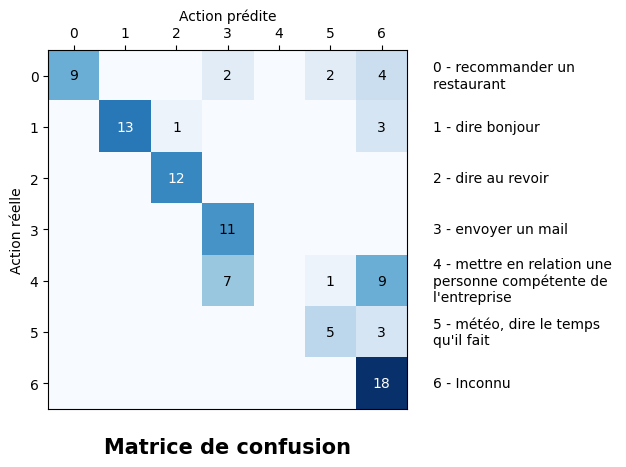

In [86]:
clf = SVC(random_state=42, kernel='poly', C=1, class_weight=sample_weights)
clf.fit(X_train, y_train)

method = "SVC4096"

results_classif()

### KNN Classifier

In [16]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

method = "KNN4096"

results_classif()

NameError: name 'results_classif' is not defined

In [88]:
query = """ah ah ah ah."""
x = embedding_func(query)
y_pred = clf.predict([x])

print(f"Prediction: {y_pred[0]}")

Prediction: dire bonjour


C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


### with PCA

In [15]:
# let's preprocess X doing a PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca = PCA(n_components=140)
X_normalized = StandardScaler().fit_transform(X)
X_pca = pca.fit_transform(X_normalized)

labels = y.unique()


y_num = y.replace({label: i for i, label in enumerate(labels)})

# shapes
print("SHAPES")
print(f"X     : {X.shape}")
print(f"X_pca : {X_pca.shape}")

plt.figure(figsize=(10, 10))
# 3D plot with the first 3 components
ax = plt.axes(projection='3d')
for i, label in enumerate(labels):
    if label not in ["dire bonjour", "dire au revoir", "envoyer un mail"]:
        continue
    ax.scatter3D(X_pca[y_num == i, 0], X_pca[y_num == i, 1], X_pca[y_num == i, 2], label=label, s=60)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
# legend
plt.legend()


plt.title('PCA of the data')
plt.show()

C:\Users\echriston\AppData\Local\Temp\ipykernel_11216\339793435.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_num = y.replace({label: i for i, label in enumerate(labels)})


SHAPES
X     : (400, 4096)
X_pca : (400, 140)


Accuracy: 0.92
Precision: 0.9275238095238094
Recall: 0.92
F1: 0.9188131064337961


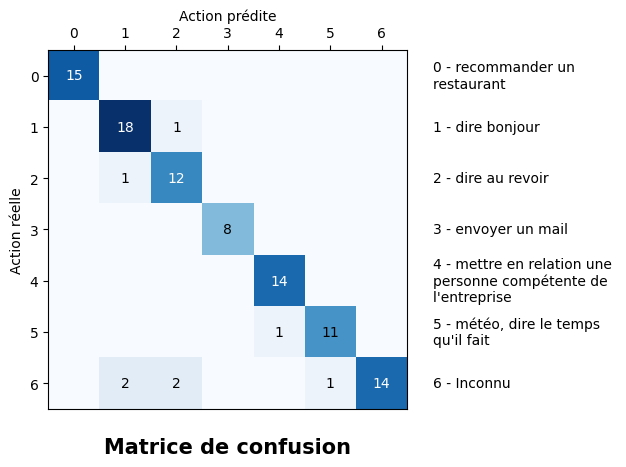

In [78]:
# new train test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

# adjusting the class
sample_weights = y.value_counts(normalize=True).to_dict()

clf = RandomForestClassifier(random_state=42, class_weight=sample_weights)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

labels = y.unique()

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted')}")
plot_confusion_matrix(y_test, y_pred, labels)

## Results

In [102]:
# load comparision_scores_df
comparision_scores_df = pd.read_csv("df_csv/comparision_scores.csv")

# replace embedding "NoneType" with "Ollama"
comparision_scores_df["embedding"] = comparision_scores_df["embedding"].replace("NoneType", "Ollama")

# sort by f1_score
comparision_scores_df = comparision_scores_df.sort_values(by="f1_score", ascending=False)

# save the comparision_scores_df
comparision_scores_df.to_csv("df_csv/comparision_scores.csv", index=False)

comparision_scores_df.head(10)

,method,embedding,model,test_len,accuracy,precision,recall,f1_score
0,RandomForest4096,Ollama,openhermes,100,0.98,0.980556,0.98,0.980000
1,RandomForest4096,Ollama,vigostral,100,0.97,0.974286,0.97,0.967692
2,RandomForest4096,Ollama,openchat,100,0.96,0.960950,0.96,0.960171
3,KNN4096,Ollama,vigostral,100,0.95,0.950436,0.95,0.948499
4,RandomForest4096,Ollama,llama3,100,0.94,0.942436,0.94,0.940429
5,KNN4096,Ollama,openchat,100,0.94,0.941944,0.94,0.940161
6,RandomForest4096,Ollama,mistral,100,0.94,0.941608,0.94,0.939977
7,KNN4096,Ollama,openhermes,100,0.93,0.938452,0.93,0.930474
8,RandomForest4096,Ollama,llama2,100,0.91,0.914843,0.91,0.908160
9,SVC4096,Ollama,vigostral,100,0.68,0.648837,0.68,0.626108
